In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GridWorld():
    def __init__(self):
        self.pos = np.array([0, 0])
        self.moves = np.array([
            [0, 1],
            [1, 1],
            [1, 0],
            [1, -1],
            [0, -1],
            [-1, -1],
            [-1, 0],
            [-1, 1]
        ])
    
    
    def is_done(self):
        return np.array_equal(self.pos, [3, 3])
    
    
    def step(self, direction):
        self.pos = np.clip(self.pos + self.moves[direction], 0, 3)
        reward = -1
        return self.pos, reward, self.is_done()


    def get_state(self):
        return self.pos
    
    
    def reset(self):
        self.pos = np.array([0, 0])
        return self.pos

In [3]:
def plot_results(opt_q, opt_action):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    cax = ax[0].matshow(opt_q, cmap='Pastel2')
    fig.colorbar(cax, ax=ax[0])
    for (i, j), val in np.ndenumerate(opt_q):
        ax[0].text(j, i, f'{val:.3f}', ha='center', va='center', color='black')
    ax[0].set_title('Optimal Q-values')
    
    # Plotting opt_action
    arrow_dict = {0: '→', 1: '↘', 2: '↓', 3: '↙', 4: '←', 5: '↖', 6: '↑', 7: '↗'}
    cax = ax[1].matshow(opt_action, cmap='cool')
    fig.colorbar(cax, ax=ax[1])
    for (i, j), val in np.ndenumerate(opt_action):
        ax[1].text(j, i, arrow_dict[val], ha='center', va='center', color='black')
    ax[1].set_title('Optimal Actions')
    
    plt.show()

In [4]:
def run_episode(agent):
    env = GridWorld()
    
    for _ in range(10000):
        done = False
        history = []
        
        state = env.reset()
        while not done:
            action = agent.select_action(state)
            next_state, reward, done = env.step(action)
            if agent.name == 'MC':
                history.append((state, action, reward, next_state))
            else:
                agent.update_table((state, action, reward, next_state))
            state = next_state
        if agent.name == 'MC':
            agent.update_table(history)
        agent.anneal_epsilon()
    
    opt_q, opt_action = agent.show_table()
    plot_results(opt_q, opt_action)

# 1. MC Control

In [5]:
class AgentMC():
    def __init__(self):
        self.q_table = np.zeros((4, 4, 8))
        self.epsilon = 0.9
        self.alpha = 0.01
        self.epsilon_decay = 0.03
        self.name = 'MC'
    
    
    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 7)
        else:
            return np.argmax(self.q_table[state[0], state[1], :])
    
    
    def update_table(self, history):
        cum_reward = 0
        for state, action, reward, _ in reversed(history):
            x, y = state
            self.q_table[x, y, action] += self.alpha * (cum_reward - self.q_table[x, y, action])
            cum_reward += reward
    
    
    def anneal_epsilon(self):
        self.epsilon = max(0.1, self.epsilon - self.epsilon_decay)
    
    
    def show_table(self):
        best_q_value = np.max(self.q_table, axis=2)
        best_action = np.argmax(self.q_table, axis=2)
        return best_q_value, best_action

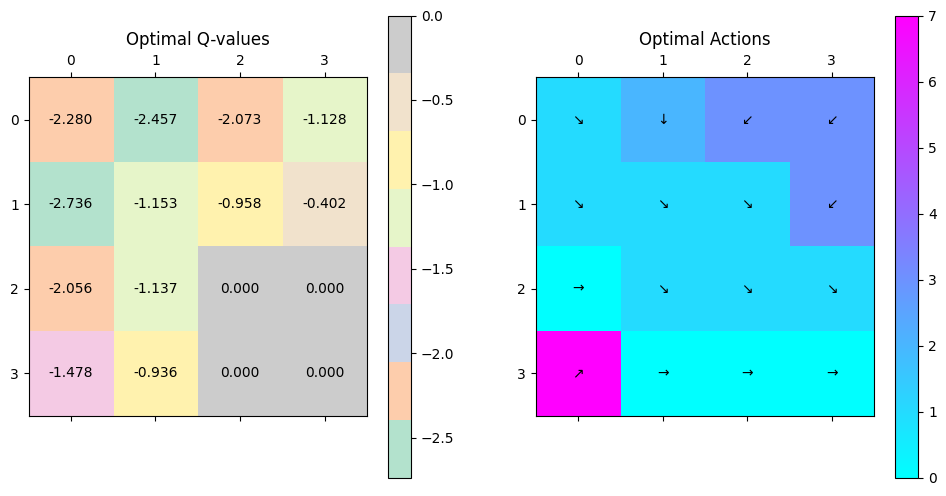

In [6]:
run_episode(AgentMC())

# 2. SARSA

In [8]:
class AgentSARSA():
    def __init__(self):
        self.q_table = np.zeros((4, 4, 8))
        self.epsilon = 0.9
        self.alpha = 0.01
        self.epsilon_decay = 0.03
        self.name = 'SARSA'
    
    
    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 7)
        else:
            return np.argmax(self.q_table[state[0], state[1], :])
    
    
    def update_table(self, transition):
        state, action, reward, next_state = transition
        x, y = state
        next_x, next_y = next_state
        next_action = self.select_action(next_state)
        self.q_table[x, y, action] += self.alpha * (reward + self.q_table[next_x, next_y, next_action] - self.q_table[x, y, action])
    
    
    def anneal_epsilon(self):
        self.epsilon = max(0.1, self.epsilon - self.epsilon_decay)
    
    
    def show_table(self):
        best_q_value = np.max(self.q_table, axis=2)
        best_action = np.argmax(self.q_table, axis=2)
        return best_q_value, best_action

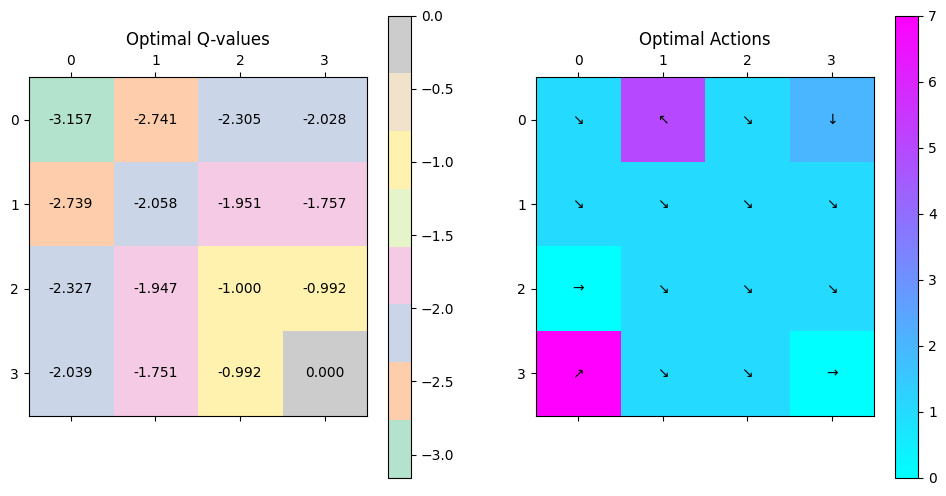

In [9]:
run_episode(AgentSARSA())

# 3. Q-Learning

In [10]:
class AgentQLearning():
    def __init__(self):
        self.q_table = np.zeros((4, 4, 8))
        self.epsilon = 0.9
        self.alpha = 0.01
        self.epsilon_decay = 0.03
        self.name = 'Q-Learning'
    
    
    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 7)
        else:
            return np.argmax(self.q_table[state[0], state[1], :])
    
    
    def update_table(self, transition):
        state, action, reward, next_state = transition
        x, y = state
        next_x, next_y = next_state
        self.q_table[x, y, action] += self.alpha * (reward + np.max(self.q_table[next_x, next_y, :]) - self.q_table[x, y, action])
    
    
    def anneal_epsilon(self):
        self.epsilon = max(0.1, self.epsilon - self.epsilon_decay)
    
    
    def show_table(self):
        best_q_value = np.max(self.q_table, axis=2)
        best_action = np.argmax(self.q_table, axis=2)
        return best_q_value, best_action

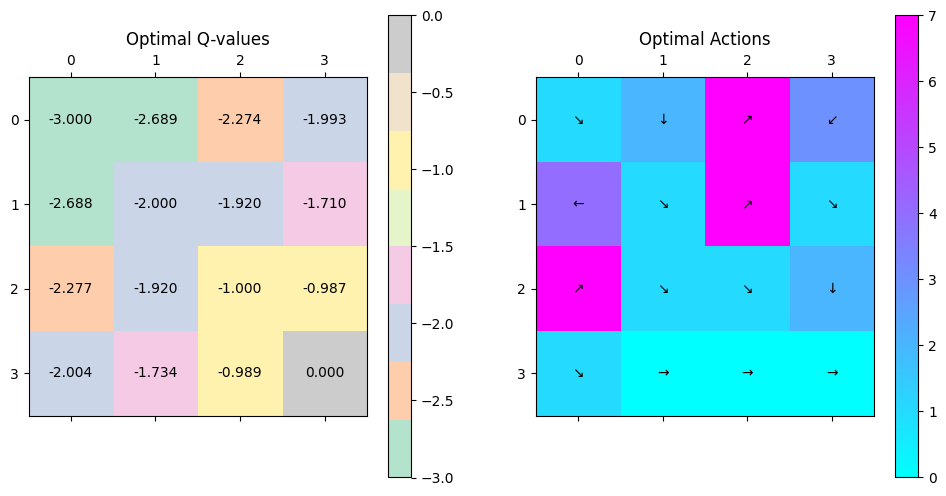

In [11]:
run_episode(AgentQLearning())